# Exploración de los Datos (EDA)

El juego de datos de "Microsoft Azure Predictive Maintenance" contiene 5 archivos tipo CSV:

- **PdM_telemetry.csv** (Telemetría de los sensores): Colección de datos de los sensores de voltaje, rotación, presión y vibración estadísticamente agrupados por su  media horaria. Contiene los datos de 100 máquinas durante el año 2015.

- **PdM_errors.csv** (Error en las máquinas): Errores registrados durante la producción de las máquinas sin necesidad de parada de producción (sin rotura ni fallo). Los datos se presentan redondeados a la hora más cercana del suceso.

- **PdM_maint.csv** (Mantenimiento de las máquinas): Registro de parada de prducción y reemplazos de componentes de una máquina tanto por Mantenimiento Proactivo (parada programada) como por rotura/fallo de la máquina (Mantenimiento Reactivo). Los datos se presentan redondeados a la hora más cercana del suceso.

- **PdM_failures.csv** (Fallo/Rotura de las máquinas): Estos datos son un subconjunto del archivo PdM_maint.csv, donde solamente aparecen las roturas/fallos de las máquinas. Los datos se presentan redondeados a la hora más cercana del suceso.

- **PdM_Machines.csv** (Especificaciones de las máquinas): Registro de los modelos y edad de las máquinas.

## Importación de Librerías

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle

from statistics import mean
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from os.path import exists

matplotlib.style.use("Solarize_Light2")

%matplotlib inline

## Carga de datos

In [2]:
# Definición del directorio del juego de datos original
directorio_datos_originales = "C:\\PdM\\datasets\\00_dataset_original\\"

path_telemetry = f"{directorio_datos_originales}PdM_telemetry.csv"
path_machines = f"{directorio_datos_originales}/PdM_machines.csv"
path_failures = f"{directorio_datos_originales}/PdM_failures.csv"
path_maint = f"{directorio_datos_originales}/PdM_maint.csv"
path_errors = f"{directorio_datos_originales}/PdM_errors.csv"


# Carga de los 5 archivo CSV y transformación de los mismos en dataframes
telemetry_df = pd.read_csv(path_telemetry)
errors_df = pd.read_csv(path_errors)
maint_df = pd.read_csv(path_maint)
failures_df = pd.read_csv(path_failures)
machines_df = pd.read_csv(path_machines)

### Archivos originales

#### **PdM_telemetry.csv:**
#### Visualización formato archivo y datos varios

In [3]:
# Datos varios
print(f"Dimensiones del PdM_telemetry.csv: {telemetry_df.shape[0]} filas y {telemetry_df.shape[1]} columnas.")
print(f"Número de máquinas sobre las que se disponen datos: {telemetry_df.machineID.nunique()}")

# Missing Data
print("Missing Data:")
if pd.date_range(start="2015-01-01 06:00:00", end="2016-01-01 06:00:00", freq="H").difference(telemetry_df.datetime).size == 0:
    print("   La telemetría tiene datos en todas las horas")
else:
    print("   Hay horas sin datos.")

# Existencia de dupliados
print("Existencia de duplicados:")
if telemetry_df.duplicated(subset=["datetime", "machineID"], keep=False).sum() == 0:
    print("   La telemetría no tiene datos duplicados datetime/machineID")
else:
    print("   Existen datos duplicados.")   

# Existencia de valores nulos
print("Existencia de valores nulos:")
if sum(list(telemetry_df.isna().sum())) == 0:
    print("   La telemetría no tiene valores nulos")
else:
    print("   Existen datos valores nulos.") 
    
# Visualización datos
print("\n")
print("Visualización datos - Primeras y Últimas 5 filas: ")
pd.concat([pd.DataFrame(telemetry_df.head()), pd.DataFrame(telemetry_df.tail())])

Dimensiones del PdM_telemetry.csv: 876100 filas y 6 columnas.
Número de máquinas sobre las que se disponen datos: 100
Missing Data:
   La telemetría tiene datos en todas las horas
Existencia de duplicados:
   La telemetría no tiene datos duplicados datetime/machineID
Existencia de valores nulos:
   La telemetría no tiene valores nulos


Visualización datos - Primeras y Últimas 5 filas: 


datetime  machineID        volt      rotate    pressure  \
0       2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1       2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2       2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3       2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4       2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   
876095  2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
876096  2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
876097  2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
876098  2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
876099  2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

        vibration  
0       45.087686  
1       43.413973  
2       34.178847  
3       41.122144  
4       25.990511  
876095  50.771941  
876096  35.123072  
876097  48.314561  
876098  44.835259  
876099  37.845245

#### **PdM_errors.csv:**
#### Visualización formato archivo y datos varios

In [4]:
# Datos varios
print(f"Dimensiones del PdM_errors.csv: {errors_df.shape[0]} filas y {errors_df.shape[1]} columnas.")
print(f"Número de errores diferentes: {errors_df.errorID.nunique()} -> {list(errors_df.errorID.value_counts().index)}")
print(f"Número de máquinas sobre las que se disponen datos: {errors_df.machineID.nunique()}")

# Existencia de dupliados
print("Existencia de duplicados:")
if errors_df.duplicated(subset=["datetime", "machineID", "errorID"], keep=False).sum() == 0:
    print("   Los datos sobre errores no tiene datos duplicados datetime/machineID/errorID")
else:
    print("   Existen datos duplicados.")  

# Existencia de valores nulos
print("Existencia de valores nulos:")
if sum(list(errors_df.isna().sum())) == 0:
    print("   Los datos sobre errores no tiene valores nulos")
else:
    print("   Existen datos valores nulos.") 

# Visualización datos
print("\n")
print("Visualización datos - Primeras y Últimas 5 filas: ")
pd.concat([pd.DataFrame(errors_df.head()), pd.DataFrame(errors_df.tail())])

Dimensiones del PdM_errors.csv: 3919 filas y 3 columnas.
Número de errores diferentes: 5 -> ['error1', 'error2', 'error3', 'error4', 'error5']
Número de máquinas sobre las que se disponen datos: 100
Existencia de duplicados:
   Los datos sobre errores no tiene datos duplicados datetime/machineID/errorID
Existencia de valores nulos:
   Los datos sobre errores no tiene valores nulos


Visualización datos - Primeras y Últimas 5 filas: 


datetime  machineID errorID
0     2015-01-03 07:00:00          1  error1
1     2015-01-03 20:00:00          1  error3
2     2015-01-04 06:00:00          1  error5
3     2015-01-10 15:00:00          1  error4
4     2015-01-22 10:00:00          1  error4
3914  2015-11-21 08:00:00        100  error2
3915  2015-12-04 02:00:00        100  error1
3916  2015-12-08 06:00:00        100  error2
3917  2015-12-08 06:00:00        100  error3
3918  2015-12-22 03:00:00        100  error3

#### **PdM_maint.csv:** 
#### Visualización formato archivo y datos varios

In [5]:
# Datos varios
print(f"Dimensiones del PdM_maint.csv: {maint_df.shape[0]} filas y {maint_df.shape[1]} columnas.")
print(f"Número de mantenimiento diferentes: {maint_df.comp.nunique()} -> {list(maint_df.comp.value_counts().index)}")

print(f"Número de máquinas sobre las que se disponen datos: {maint_df.machineID.nunique()}")

# Visualización datos
print("\n")
print("Visualización datos  - Primeras y Últimas 5 filas: ")
pd.concat([pd.DataFrame(maint_df.head()), pd.DataFrame(maint_df.tail())])


Dimensiones del PdM_maint.csv: 3286 filas y 3 columnas.
Número de mantenimiento diferentes: 4 -> ['comp2', 'comp4', 'comp3', 'comp1']
Número de máquinas sobre las que se disponen datos: 100


Visualización datos  - Primeras y Últimas 5 filas: 


datetime  machineID   comp
0     2014-06-01 06:00:00          1  comp2
1     2014-07-16 06:00:00          1  comp4
2     2014-07-31 06:00:00          1  comp3
3     2014-12-13 06:00:00          1  comp1
4     2015-01-05 06:00:00          1  comp4
3281  2015-10-10 06:00:00        100  comp3
3282  2015-10-25 06:00:00        100  comp4
3283  2015-11-09 06:00:00        100  comp4
3284  2015-12-09 06:00:00        100  comp2
3285  2015-12-24 06:00:00        100  comp2

#### **PdM_failures.csv:**
#### Visualización formato archivo y datos varios

In [6]:
# Datos varios
print(f"Dimensiones del PdM_failures.csv: {failures_df.shape[0]} filas y {failures_df.shape[1]} columnas.")
print(f"Número de fallos/roturas diferentes: {failures_df.failure.nunique()} -> {list(failures_df.failure.value_counts().index)}")
print(f"Número de máquinas sobre las que se disponen datos: {failures_df.machineID.nunique()}")

for i in range(1,101):
    if i not in list(failures_df.machineID):
        print(f"   No hay fallos/roturas en la máquina: {i}")

# Visualización datos
print("\n")
print("Visualización datos - Primeras y Últimas 5 filas: ")
pd.concat([pd.DataFrame(failures_df.head()), pd.DataFrame(failures_df.tail())])

Dimensiones del PdM_failures.csv: 761 filas y 3 columnas.
Número de fallos/roturas diferentes: 4 -> ['comp2', 'comp1', 'comp4', 'comp3']
Número de máquinas sobre las que se disponen datos: 98
   No hay fallos/roturas en la máquina: 6
   No hay fallos/roturas en la máquina: 77


Visualización datos - Primeras y Últimas 5 filas: 


datetime  machineID failure
0    2015-01-05 06:00:00          1   comp4
1    2015-03-06 06:00:00          1   comp1
2    2015-04-20 06:00:00          1   comp2
3    2015-06-19 06:00:00          1   comp4
4    2015-09-02 06:00:00          1   comp4
756  2015-11-29 06:00:00         99   comp3
757  2015-12-14 06:00:00         99   comp4
758  2015-02-12 06:00:00        100   comp1
759  2015-09-10 06:00:00        100   comp1
760  2015-12-09 06:00:00        100   comp2

#### **PdM_machines.csv:**
#### Visualización formato archivo y datos varios

In [7]:
# Datos varios
print(f"Dimensiones del PdM_machines.csv: {machines_df.shape[0]} filas y {machines_df.shape[1]} columnas.")
print(f"Número de máquinas diferentes: {machines_df.machineID.nunique()}")
ages = list(machines_df.age.value_counts().index)
print(f"Número de edades diferentes: {machines_df.age.nunique()} -> {ages}")
print(f"   Edad mínima: {min(ages)}")
print(f"   Edad máxima: {max(ages)}")
print(f"   Edad media: {mean(ages)}")

# Visualización datos
print("\n")
print("Visualización datos - Primeras y Últimas 5 filas: ")
pd.concat([pd.DataFrame(machines_df.head()), pd.DataFrame(machines_df.tail())])

Dimensiones del PdM_machines.csv: 100 filas y 3 columnas.
Número de máquinas diferentes: 100
Número de edades diferentes: 20 -> [14, 10, 20, 17, 18, 2, 15, 7, 16, 9, 5, 19, 6, 3, 4, 1, 11, 12, 0, 8]
   Edad mínima: 0
   Edad máxima: 20
   Edad media: 9.85


Visualización datos - Primeras y Últimas 5 filas: 


machineID   model  age
0           1  model3   18
1           2  model4    7
2           3  model3    8
3           4  model3    7
4           5  model3    2
95         96  model2   10
96         97  model2   14
97         98  model2   20
98         99  model1   14
99        100  model4    5

**Nota:**  
Se observa que algunos archivos poseen datos de los años 2014 y 2016. Estos no serán utilizados por compatibilidad temporal, es decir, solamente se tendrán en cuenta los datos del año 2015.

## Visualizaciones Telemetría

Elaboraremos una lista de listas con la información por cada máquina donde se expone el **índice (o número de fila)** del archivo "PdM_telemetry.csv" y el **componente** afectado para cada fallo/rotura del juego de datos.

In [8]:
num_machines_to_plot = 100

file_with_lists_exists = True

if file_with_lists_exists:
    pkl_file = open("num_machines_to_plot.pkl",'rb')
    failure_data_list = pickle.load(pkl_file)

else:
    # Primer elemento vacío para cuadrar el número del índice con el número de máquina
    failure_data_list = [[]]
    for i in range(1, num_machines_to_plot + 1):
        dates_failure_by_machine = list(failures_df[failures_df.apply(lambda x: x["machineID"] == i, axis=1)]["datetime"])
        comp_failure_by_machine = list(failures_df[failures_df.apply(lambda x: x["machineID"] == i, axis=1)]["failure"])    
        dates_telemetry = list(telemetry_df[telemetry_df.apply(lambda x: x["machineID"] == i, axis=1)]["datetime"])
        failure_data_list_by_machine = []
        for index_date, date in enumerate(dates_telemetry):
            for index_failure, date_failure in enumerate(dates_failure_by_machine):
                if date_failure == date:
                    tupla_ = (index_date, comp_failure_by_machine[index_failure])
                    failure_data_list_by_machine.append(tupla_)
        failure_data_list.append(failure_data_list_by_machine)
    pkl_file = open('num_machines_to_plot.pkl','wb')
    pickle.dump(failure_data_list,pkl_file)

# Ejemplo máquina 1
print("Ejemplo del resultado para la Máquina 1:")
failure_data_list[1]

Ejemplo del resultado para la Máquina 1:


[(96, 'comp4'),
 (1536, 'comp1'),
 (2616, 'comp2'),
 (4056, 'comp4'),
 (5856, 'comp4'),
 (6936, 'comp2'),
 (8376, 'comp4')]

El juego de datos original posee datos de **100 máquinas diferentes**, pero como se observa, las máquinas pertenecen a **diferentes modelos y edades**.   
En consecuencia, no sería correcto comparar máquinas con características diferentes si queremos predecir sus fallos.  
A continuación se exponen las máquinas de un mismo modelo, misma edad, y mismo modelo y edad para poder elegir consecuentemente las máquinas y compararlas en nuestro algoritmo.


#### Desglose de Máquinas por Modelos

In [9]:
def get_machines_by_model(machines_df):
    """Retorna un diccionario con las IDs de las máquinas por modelo"""
    models = list(machines_df.model.value_counts().index)

    dict_machines_by_models = {}
    for model in models:
        dict_machines_by_models[str(model)] = []

    machineID_machines = list(machines_df.machineID)
    models_machines = list(machines_df.model)

    for model in models:
        for ind_model_machine, model_machine in enumerate(models_machines):
            if model_machine == model:
                dict_machines_by_models[str(model)].append(machineID_machines[ind_model_machine])

    return dict_machines_by_models

print("Máquinas con modelo:")
for key in get_machines_by_model(machines_df):

    print(f"       {key}: {get_machines_by_model(machines_df)[key]}")



Máquinas con modelo:
       model3: [1, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 18, 19, 26, 27, 30, 33, 43, 45, 52, 53, 55, 59, 64, 65, 68, 70, 75, 79, 80, 82, 84, 86, 89, 93]
       model4: [2, 9, 25, 28, 29, 32, 34, 36, 38, 39, 41, 44, 46, 48, 50, 51, 57, 60, 61, 62, 63, 66, 67, 72, 74, 77, 78, 81, 83, 88, 91, 100]
       model2: [11, 20, 21, 40, 47, 54, 69, 71, 73, 76, 87, 90, 94, 95, 96, 97, 98]
       model1: [13, 16, 17, 22, 23, 24, 31, 35, 37, 42, 49, 56, 58, 85, 92, 99]


#### Desglose de Máquinas por Edades

In [10]:
def get_machines_by_age(machines_df):
    """Retorna un diccionario con las IDs de las máquinas por edad"""
    ages = list(machines_df.age.value_counts().index)

    dict_machines_by_ages = {}
    for age in ages:
        dict_machines_by_ages[str(age)] = []

    machineID_machines = list(machines_df.machineID)
    ages_machines = list(machines_df.age)

    for age in ages:
        for ind_age_machine, age_machine in enumerate(ages_machines):
            if age_machine == age:
                dict_machines_by_ages[str(age)].append(machineID_machines[ind_age_machine])

    return dict_machines_by_ages

print("Máquinas con antiguedad de:")
for key in get_machines_by_age(machines_df):

    print(f"       {key} años: {get_machines_by_age(machines_df)[key]}")

Máquinas con antiguedad de:
       14 años: [15, 17, 21, 22, 33, 43, 45, 52, 63, 67, 79, 88, 97, 99]
       10 años: [10, 34, 46, 48, 54, 56, 57, 68, 76, 96]
       20 años: [7, 24, 30, 62, 64, 73, 98]
       17 años: [19, 23, 35, 55, 59, 89, 91]
       18 años: [1, 71, 83, 93, 94, 95]
       2 años: [5, 61, 72, 86, 90, 92]
       15 años: [13, 18, 32, 38, 49, 65]
       7 años: [2, 4, 6, 9, 42, 44]
       16 años: [8, 20, 25, 37, 85]
       9 años: [12, 27, 41, 70, 84]
       5 años: [36, 53, 58, 100]
       19 años: [51, 69, 75, 78]
       6 años: [11, 47, 66, 80]
       3 años: [16, 26, 29, 60]
       4 años: [40, 50, 74]
       1 años: [14, 28, 81]
       11 años: [31, 82]
       12 años: [77, 87]
       0 años: [39]
       8 años: [3]


#### Desglose de Máquinas por Modelos y Edades
Observamos que el número máximo de máquinas de igual modelo y edad es para el modelo 3 y antiguedad de 14 años.  
Por tanto, este tipo de máquinas podría ser un buen candidato para nuestro estudio por tener mayor cantidad de datos similares.

In [11]:
def get_machines_by_age_and_model(model, age, data_machine_model, data_machine_age):
    """Retorna una lista con las IDs de las máquinas comunes por modelo y edad"""
    machine_model_age = []
    machine_model = data_machine_model[str(model)]
    machine_age = data_machine_age[str(age)]
    for i in machine_model:
        for j in machine_age:
            if i == j:
                machine_model_age.append(i)
    return machine_model_age

# Agrupación de las IDs de la máquinas según su modelo y edad
list_machine_models = get_machines_by_model(machines_df) 
list_machine_ages = get_machines_by_age(machines_df)
dict_machines_by_models_and_ages = {}

print("Máquinas agrupadas por modelo y edad: ")
for model in list_machine_models:
    for age in list_machine_ages:
        if get_machines_by_age_and_model(model, str(age), list_machine_models, list_machine_ages) != []:
            dict_machines_by_models_and_ages[f"{model} y edad {age}"] = get_machines_by_age_and_model(model, str(age), list_machine_models, list_machine_ages)
dict_machines_by_models_and_ages

Máquinas agrupadas por modelo y edad: 


{'model3 y edad 14': [15, 33, 43, 45, 52, 79],
 'model3 y edad 10': [10, 68],
 'model3 y edad 20': [7, 30, 64],
 'model3 y edad 17': [19, 55, 59, 89],
 'model3 y edad 18': [1, 93],
 'model3 y edad 2': [5, 86],
 'model3 y edad 15': [18, 65],
 'model3 y edad 7': [4, 6],
 'model3 y edad 16': [8],
 'model3 y edad 9': [12, 27, 70, 84],
 'model3 y edad 5': [53],
 'model3 y edad 19': [75],
 'model3 y edad 6': [80],
 'model3 y edad 3': [26],
 'model3 y edad 1': [14],
 'model3 y edad 11': [82],
 'model3 y edad 8': [3],
 'model4 y edad 14': [63, 67, 88],
 'model4 y edad 10': [34, 46, 48, 57],
 'model4 y edad 20': [62],
 'model4 y edad 17': [91],
 'model4 y edad 18': [83],
 'model4 y edad 2': [61, 72],
 'model4 y edad 15': [32, 38],
 'model4 y edad 7': [2, 9, 44],
 'model4 y edad 16': [25],
 'model4 y edad 9': [41],
 'model4 y edad 5': [36, 100],
 'model4 y edad 19': [51, 78],
 'model4 y edad 6': [66],
 'model4 y edad 3': [29, 60],
 'model4 y edad 4': [50, 74],
 'model4 y edad 1': [28, 81],
 'mod

## Visualizaciones
Definimos funciones auxiliares que nos ayudarán a explorar visualmente los datos.


In [12]:
df = telemetry_df[["volt", "rotate", "pressure", "vibration"]]

In [13]:
def failure_plot_date(machineID_, sensor_, label, color_, failure_data_list):
    """Visualiación de la telemetría de una máquina según un sensor definido"""
    for i in range(machineID_,machineID_ + 1):
        df = telemetry_df[telemetry_df.machineID == i][["datetime", sensor_]].set_index("datetime")
        value_max = max(df[sensor_])
        value_min = min(df[sensor_])
        time_series_graf(df,
                         title=f"Valores de {label} en Máquina {i}", 
                         xlabel="Tiempo", 
                         ylabel=label, 
                         color=color_, 
                         failures=failure_data_list[i], 
                         max_=value_max, 
                         min_=value_min)

                         
def time_series_graf(series, figsize=(25, 2), title=None, xlabel="", ylabel="", linewidth=0.1, color="black", failures=[], max_=None, min_=None):
    """Función auxiliar que añade líneas verticales a la visualización que indican el tipo de fallo y cúando sucedieron"""
    series.plot(figsize=figsize, title=title, linewidth=linewidth, color=color)
    
    for date in failures:
            if date[1] == "comp1":
                plt.vlines(x=[date[0]], ymin=min_, ymax=max_, colors='black', ls='--', lw=2.5, label='vline_multiple')
            if date[1] == "comp2":
                plt.vlines(x=[date[0]], ymin=min_, ymax=max_, colors='brown', ls='--', lw=2.5, label='vline_multiple')
            if date[1] == "comp3":
                plt.vlines(x=[date[0]], ymin=min_, ymax=max_, colors='blue', ls='--', lw=2.5, label='vline_multiple')
            if date[1] == "comp4":
                plt.vlines(x=[date[0]], ymin=min_, ymax=max_, colors='grey', ls='--', lw=2.5, label='vline_multiple')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    return

Ejemplo de Visualización de los sensores (telemetría) **según el modelo de la máquinas**:

Gráficos de la Máquina 13:
Las Máquinas son del modelo: model1
Leyenda Fallos por Componente: 
   Negro     -> Componente 1
   Marrón    -> Componente 2
   Azul      -> Componente 3
   Gris      -> Componente 4


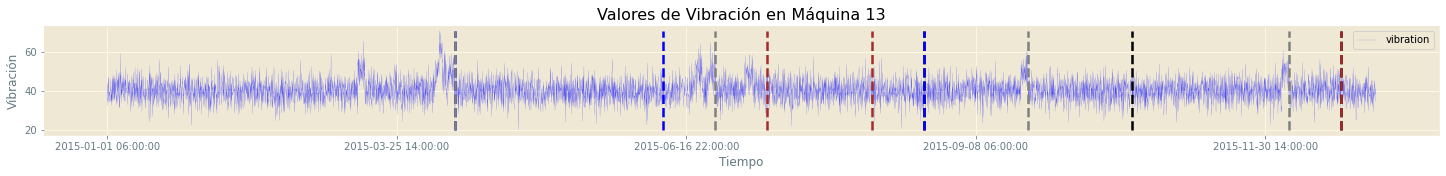

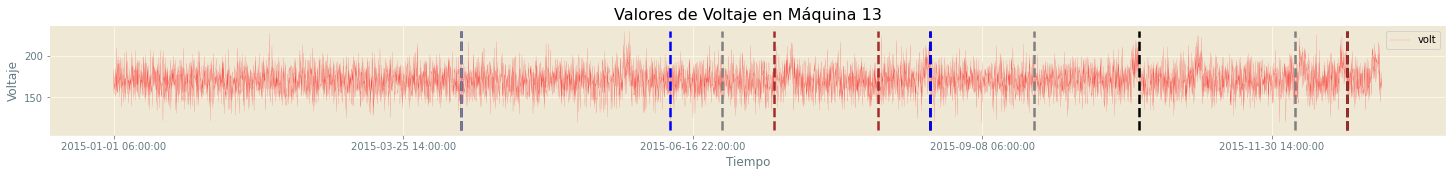

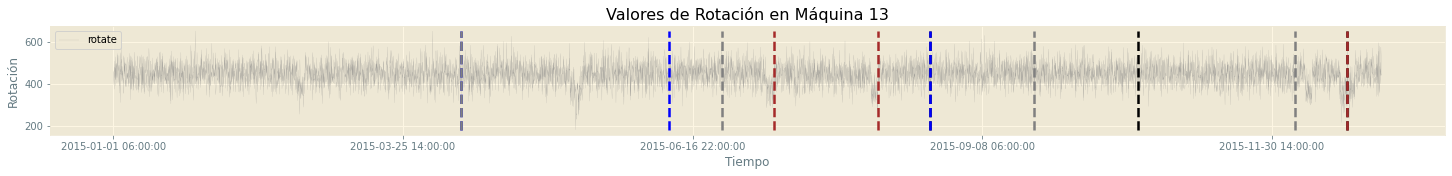

In [14]:
model_machine_list = "model1"

for i in [get_machines_by_model(machines_df)[model_machine_list][0]]:  # Ejemplo primera máquina tipo modelo 1  
    print(f"Gráficos de la Máquina {i}:")
    print(f"Las Máquinas son del modelo: {model_machine_list }")
    print("Leyenda Fallos por Componente: ")
    print("   Negro     -> Componente 1")
    print("   Marrón    -> Componente 2")
    print("   Azul      -> Componente 3")
    print("   Gris      -> Componente 4")
    failure_plot_date(i, "vibration", "Vibración", "blue", failure_data_list)
    failure_plot_date(i, "volt", "Voltaje", "red", failure_data_list)
    failure_plot_date(i, "pressure", "Presión", "green", failure_data_list)
    failure_plot_date(i, "rotate", "Rotación", "grey", failure_data_list)

Ejemplo de Visualización de los sensores (telemetría) **según la edad de la máquinas**:

Gráficos de la Máquina 3:
Las Máquinas tienen 8 años de antiguedad
Leyenda Fallos por Componente: 
   Negro     -> Componente 1
   Marrón    -> Componente 2
   Azul      -> Componente 3
   Gris      -> Componente 4


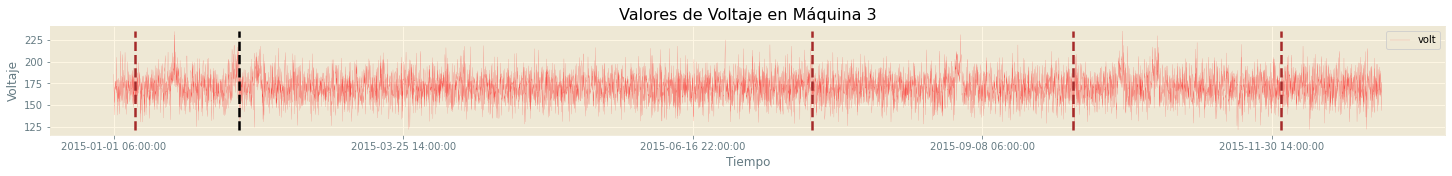

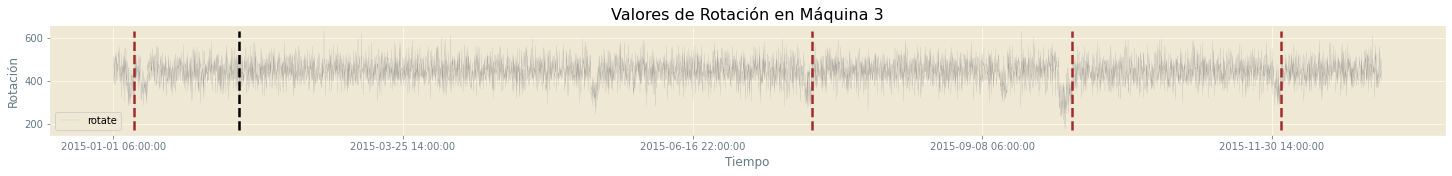

In [15]:
age_machine_list = 8

for i in get_machines_by_age(machines_df)[str(age_machine_list)]:    
    print(f"Gráficos de la Máquina {i}:")
    print(f"Las Máquinas tienen {age_machine_list } años de antiguedad")
    print("Leyenda Fallos por Componente: ")
    print("   Negro     -> Componente 1")
    print("   Marrón    -> Componente 2")
    print("   Azul      -> Componente 3")
    print("   Gris      -> Componente 4")
    failure_plot_date(i, "vibration", "Vibración", "blue", failure_data_list)
    failure_plot_date(i, "volt", "Voltaje", "red", failure_data_list)
    failure_plot_date(i, "pressure", "Presión", "green", failure_data_list)
    failure_plot_date(i, "rotate", "Rotación", "grey", failure_data_list)

Ejemplo de Visualización de los sensores (telemetría) **según la modelo y edad de la máquinas**:

Gráficos de la Máquina 34:
Las Máquinas son model4 y edad 10
Leyenda Fallos por Componente: 
   Negro     -> Componente 1
   Marrón    -> Componente 2
   Azul      -> Componente 3
   Gris      -> Componente 4


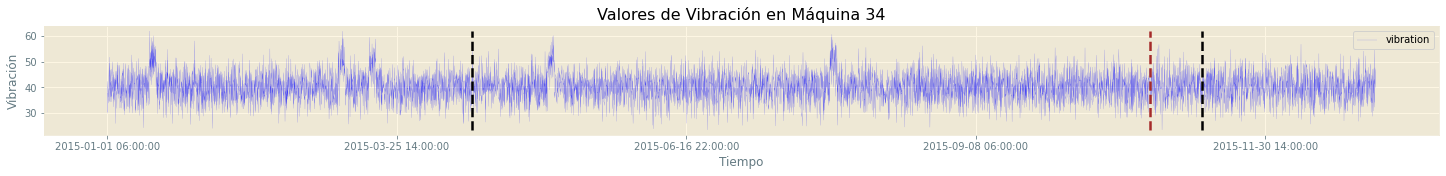

Gráficos de la Máquina 46:
Las Máquinas son model4 y edad 10
Leyenda Fallos por Componente: 
   Negro     -> Componente 1
   Marrón    -> Componente 2
   Azul      -> Componente 3
   Gris      -> Componente 4


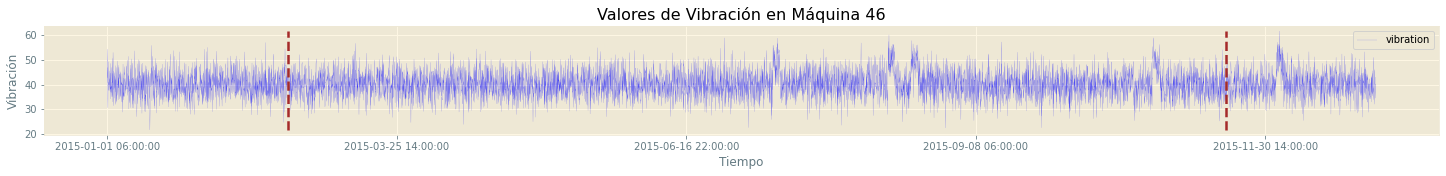

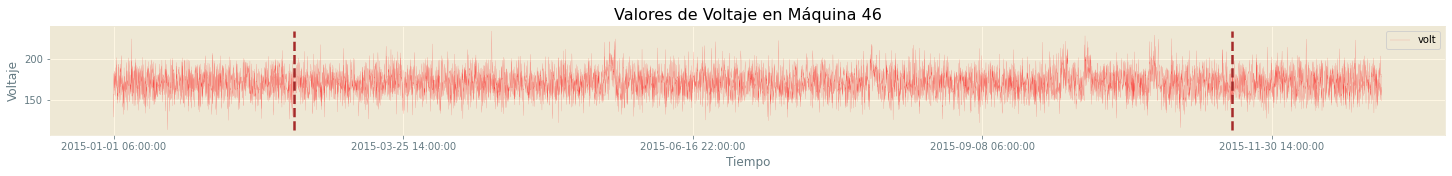

Gráficos de la Máquina 48:
Las Máquinas son model4 y edad 10
Leyenda Fallos por Componente: 
   Negro     -> Componente 1
   Marrón    -> Componente 2
   Azul      -> Componente 3
   Gris      -> Componente 4


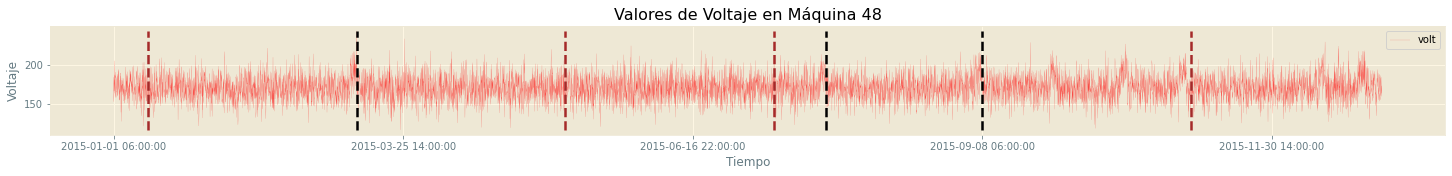

Gráficos de la Máquina 57:
Las Máquinas son model4 y edad 10
Leyenda Fallos por Componente: 
   Negro     -> Componente 1
   Marrón    -> Componente 2
   Azul      -> Componente 3
   Gris      -> Componente 4


In [16]:
model_age_machine_list = 'model4 y edad 10'

for i in dict_machines_by_models_and_ages[str(model_age_machine_list)]:    
    print(f"Gráficos de la Máquina {i}:")
    print(f"Las Máquinas son {model_age_machine_list }")
    print("Leyenda Fallos por Componente: ")
    print("   Negro     -> Componente 1")
    print("   Marrón    -> Componente 2")
    print("   Azul      -> Componente 3")
    print("   Gris      -> Componente 4")
    failure_plot_date(i, "vibration", "Vibración", "blue", failure_data_list)
    failure_plot_date(i, "volt", "Voltaje", "red", failure_data_list)
    failure_plot_date(i, "pressure", "Presión", "green", failure_data_list)
    failure_plot_date(i, "rotate", "Rotación", "grey", failure_data_list)

### Estadísticos

In [17]:
# Añadimos una columna con el mes del registro
telemetry_df["Mes"] = [x.split("-")[1] for x in telemetry_df["datetime"]]
telemetry_df["Dia"] = [x.split("-")[2].split(" ")[0] for x in telemetry_df["datetime"]]

In [18]:
telemetry_df.head()

datetime  machineID        volt      rotate    pressure  \
0  2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1  2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2  2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3  2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4  2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration Mes Dia  
0  45.087686  01  01  
1  43.413973  01  01  
2  34.178847  01  01  
3  41.122144  01  01  
4  25.990511  01  01

### Visualización de estadísticos de los sensores por días
Se observa que no se distingue ninguna particularidad en los días, siendo los estadísticos no significantes respecto al día.

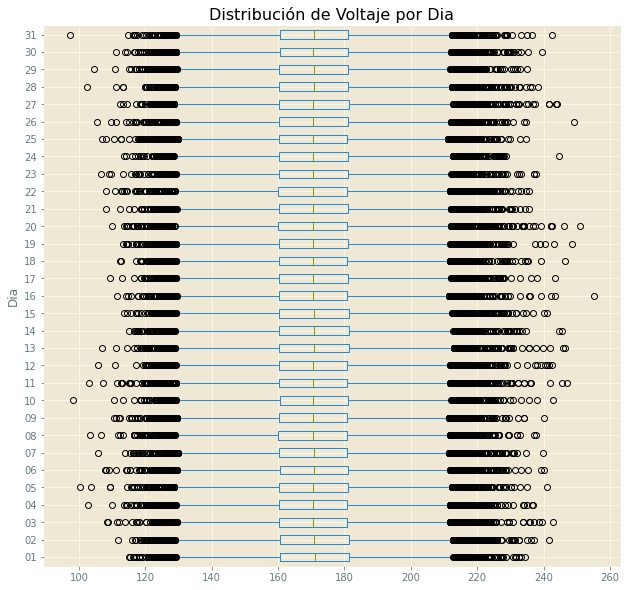

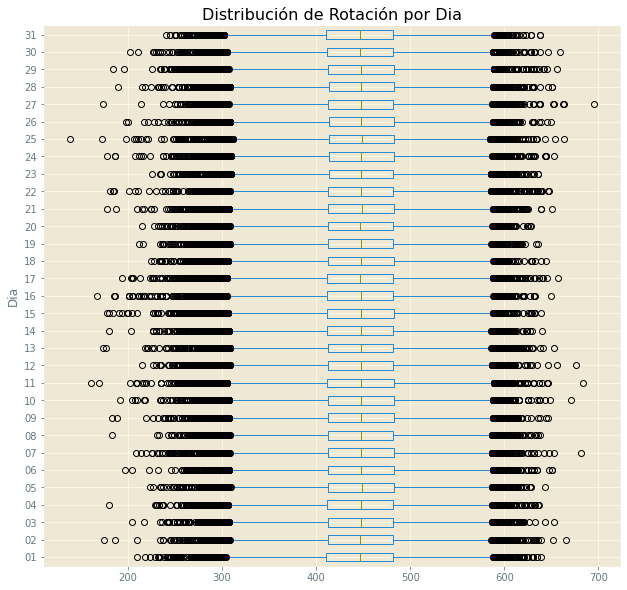

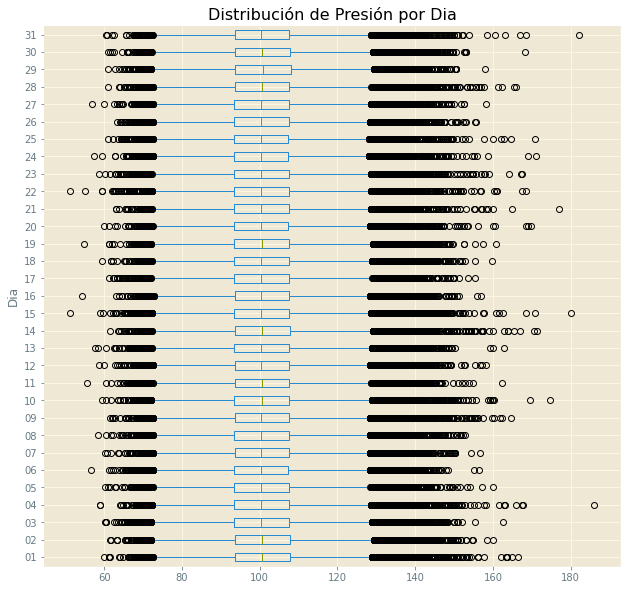

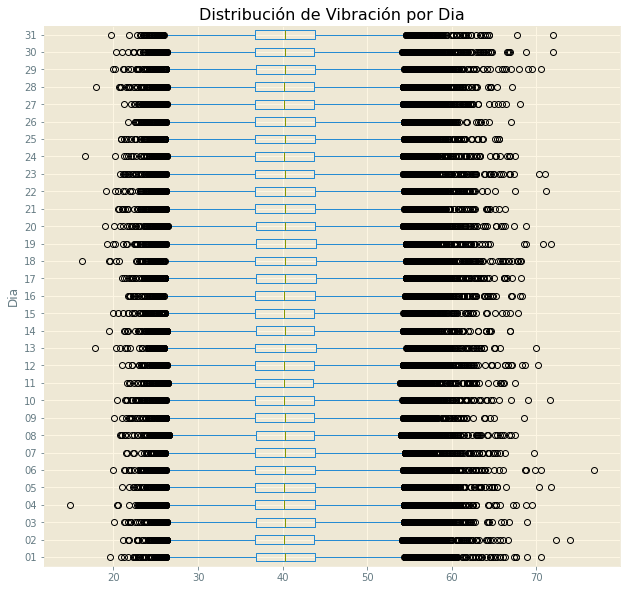

In [19]:
# Boxplots de cada sensor agrupados por meses
for i in [("volt","Voltaje"), ("rotate","Rotación"), ("pressure","Presión"), ("vibration", "Vibración")]:
    telemetry_df.boxplot(column=i[0], by="Dia", vert=False, figsize=(10, 10))
    plt.title(f'Distribución de {i[1]} por {"Dia"}')
    plt.suptitle('')
    plt.xlabel('')
    plt.ylabel("Dia")
    plt.show()

### Visualización de estadísticos de los sensores por meses
Se observa que no se distingue ninguna particularidad en los meses, siendo los estadísticos no significantes respecto al mes.

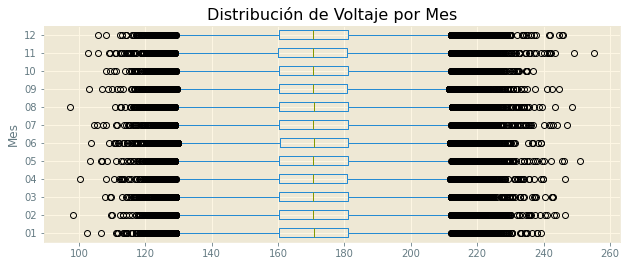

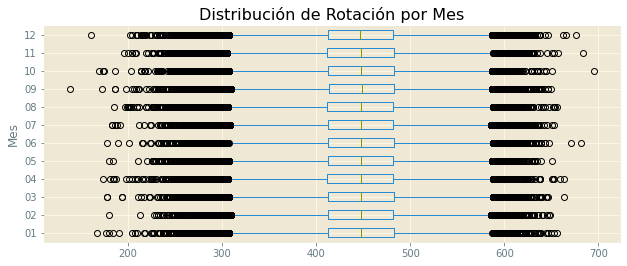

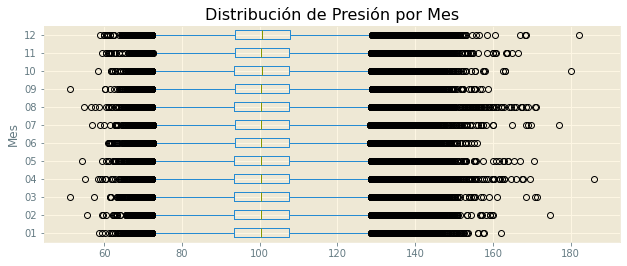

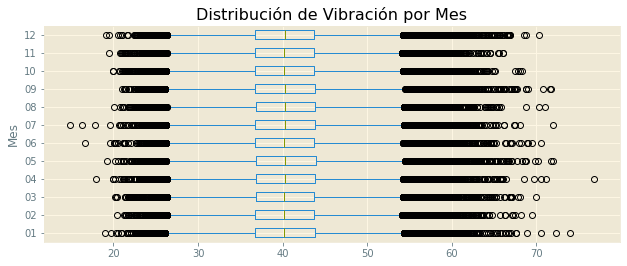

In [20]:
# Boxplots de cada sensor agrupados por meses
for i in [("volt","Voltaje"), ("rotate","Rotación"), ("pressure","Presión"), ("vibration", "Vibración")]:
    telemetry_df.boxplot(column=i[0], by="Mes", vert=False, figsize=(10, 4))
    plt.title(f'Distribución de {i[1]} por {"Mes"}')
    plt.suptitle('')
    plt.xlabel('')
    plt.ylabel("Mes")
    plt.show()

### Visualización de Histogramas de los sensores
Se observa mayor dispersión para los datos relacionados con las rotaciones.

**NOTA:**  
Los datos de los sensores se aproximan fielmente a distribuciones normales.

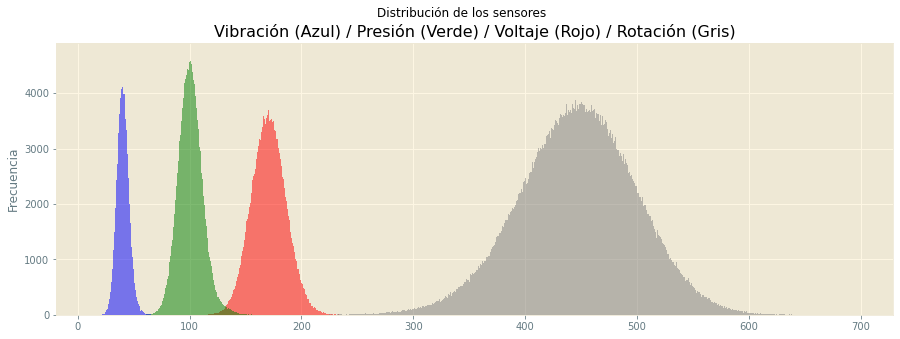

In [21]:
# Histogramas de cada sensor


for i in [("volt","Voltaje", "red"), ("rotate","Rotación", "grey"), ("pressure","Presión", "green"), ("vibration", "Vibración", "blue")]:
    df[i[0]].plot(kind='hist', bins=1000, figsize=(15, 5), title="Vibración (Azul) / Presión (Verde) / Voltaje (Rojo) / Rotación (Gris)", color=i[2], alpha=0.5)
plt.suptitle('Distribución de los sensores')
plt.ylabel("Frecuencia")
plt.show()

### Correlación entre Sensores
Viendo que los sensores siguen una distribución normal, podemos pensar que podría haber algún tipo de correlación entre los datos, aunque mostrando la matriz de correlaciones no se observan correlaciones entre los datos de los diferentes sensores

In [22]:
# Correlación entre los sensores
df.corr().style.background_gradient()

Aunque la tabla de correlaciones no indica ninguna correlación aparente, intentaremos visualizar cuándo los errores y fallos aparacen y observar si vemos algún patrón de comportamiento.  
Después de la visualización, no se observa patrón alguno.  
  
Escogemos por ejemplo la máquina 15.

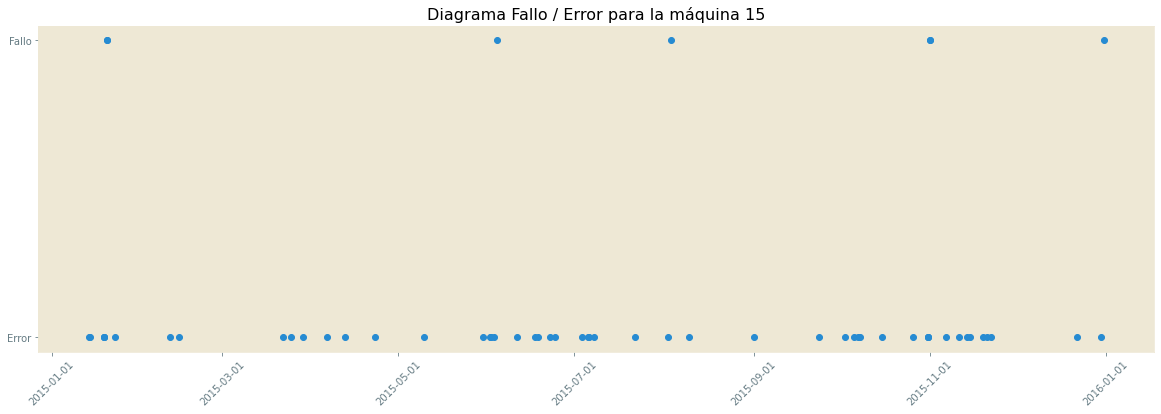

In [23]:
maquina_ = 15

# Preparación tablas
df_15 = telemetry_df.loc[telemetry_df['machineID'] == maquina_].reset_index(drop=True)
df_15_failure = failures_df.loc[failures_df['machineID'] == maquina_]
df_15_error = errors_df.loc[errors_df['machineID'] == maquina_]


fig, ax = plt.subplots(figsize=(20,6))

# Creamos los valores dicotómicos: Fallo / Error
eje_y = []

for iter in range(0, len(df_15_failure)):
  eje_y.append('Fallo')

for iter in range(0, len(df_15_error)):
  eje_y.append('Error')

# Preparación de las fechas (eje x)
df_timestamp = pd.concat([df_15_failure['datetime'], df_15_error['datetime']], ignore_index=True, axis=0)
df_plot = pd.DataFrame({"timestamp": df_timestamp, "category": eje_y})
df_plot.loc[:, 'timestamp'] = pd.to_datetime(df_plot.loc[:, 'timestamp'])
df_plot.sort_values(by=['timestamp'], inplace=True, ignore_index=True)


# Visualizamos los datos
ax.scatter('timestamp', 'category', data = df_plot)
yearfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(yearfmt)
plt.title(f"Diagrama Fallo / Error para la máquina {maquina_}")
ax.tick_params(axis='x', rotation=45)
ax.grid()

### Autocorrelación  Autocorrelación Parcial entre Sensores
En series temporales se pueden encontrar correlaciones entre series de los mismos datos pero decalados en un cierto valor "lag".  
No se observa una autocorrelación o autocorrelación parcial importante entre las series temporales de los sensores.

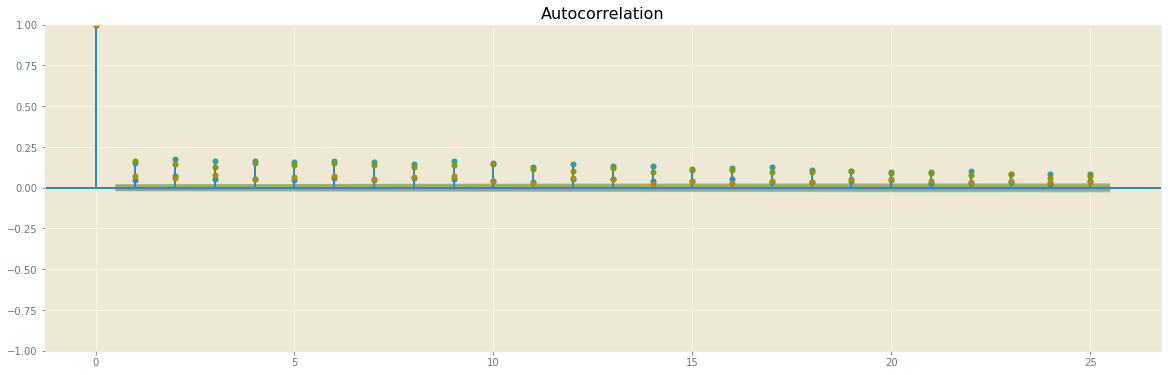

In [24]:
maquina_ = 15
df_15 = telemetry_df.loc[telemetry_df['machineID'] == maquina_].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(20, 6))

# Autocorrelation plot
for type_ in ["volt", "vibration", "pressure", "rotate"]:
    plot_acf(df_15[type_], lags = 25, ax=ax)
plt.show()

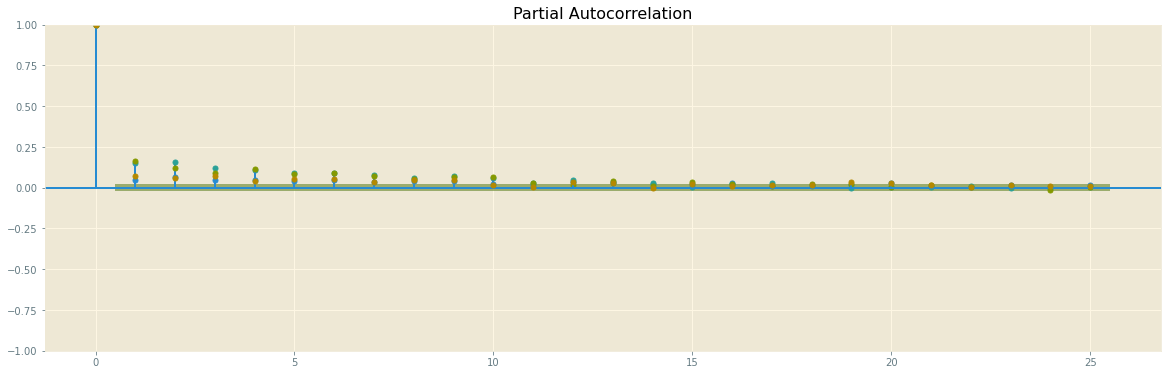

In [25]:
maquina_ = 15
df_15 = telemetry_df.loc[telemetry_df['machineID'] == maquina_].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(20, 6))

# Autocorrelation plot
for type_ in ["volt", "vibration", "pressure", "rotate"]:
    plot_pacf(df_15[type_], lags = 25, ax=ax)
plt.show()

### Exploración Errores

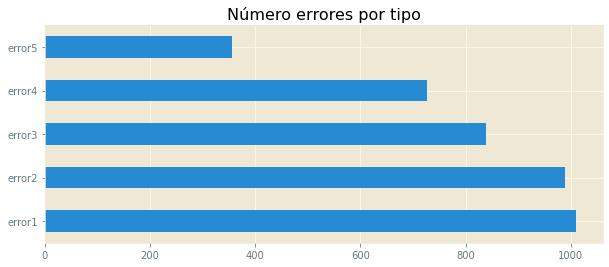

In [26]:
errors_df["errorID"].value_counts(normalize=False, dropna=False).sort_index().plot(kind='barh', figsize=(10, 4), grid=True, title="Número errores por tipo")
plt.show()

In [27]:
errors_df["machineID"].value_counts(normalize=False, dropna=False).sort_index().plot(kind='bar', figsize=(20, 6), grid=True, title="Número de errores por máquina")
plt.show()

### Exploración Mantenimiento

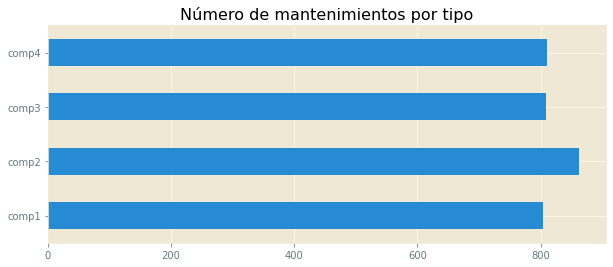

In [28]:
maint_df["comp"].value_counts(normalize=False, dropna=False).sort_index().plot(kind='barh', figsize=(10, 4), grid=True, title="Número de mantenimientos por tipo")
plt.show()

In [29]:
maint_df["machineID"].value_counts(normalize=False, dropna=False).sort_index().plot(kind='bar', figsize=(20, 6), grid=True, title="Número de mantenimientos por máquina")
plt.show()

### Exploración Fallos

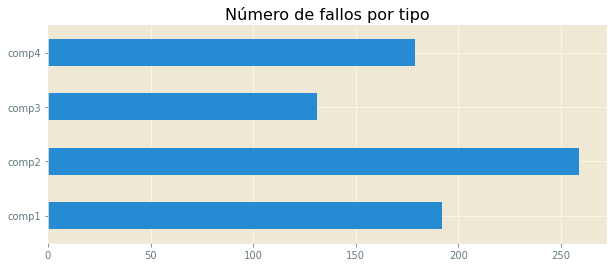

In [30]:
failures_df["failure"].value_counts(normalize=False, dropna=False).sort_index().plot(kind='barh', figsize=(10, 4), grid=True, title="Número de fallos por tipo")
plt.show()

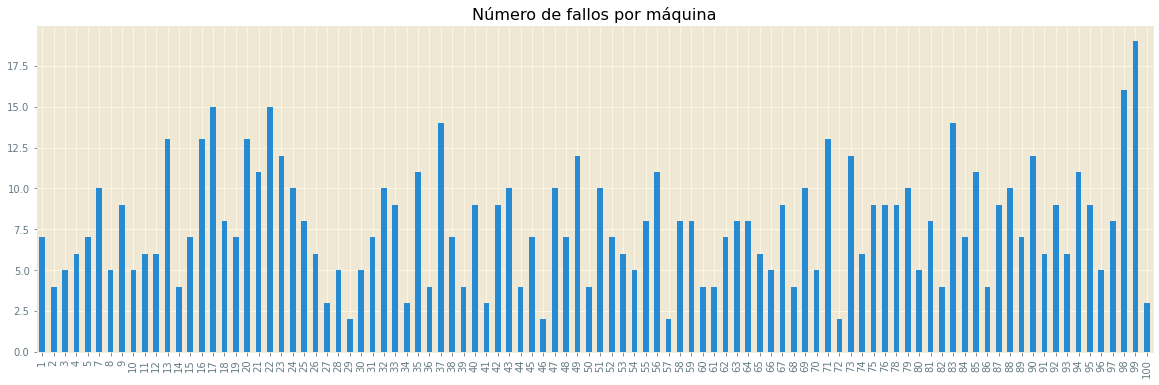

In [31]:
failures_df["machineID"].value_counts(normalize=False, dropna=False).sort_index().plot(kind='bar', figsize=(20, 6), grid=True, title="Número de fallos por máquina")
plt.show()

### Exploración de fallos for componente y máquina

**NOTA:**  
Se observa que, aunque el número de fallos del componente 3 es el menor de todos los componentes, es el mismo componente el que falla más veces por máquina.

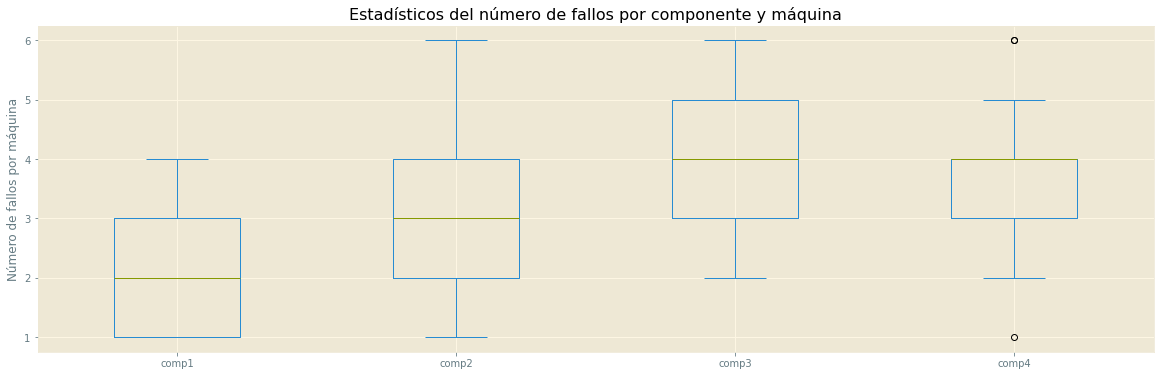

In [32]:
df_failure_group = failures_df.groupby(["machineID", "failure"]).size().reset_index()
df_failure_group.columns = ["machineID", "failure", "num_failure"]
df_failure_pivot = pd.pivot(df_failure_group, index="machineID", columns="failure", values="num_failure").rename_axis(None, axis=1)

df_failure_pivot.plot.box(stacked=False, figsize=(20, 6), title="Estadísticos del número de fallos por componente y máquina")
plt.xlabel("")
plt.ylabel("Número de fallos por máquina");

### Generación de un archivo CSV combinado que engloba todos los datos originales (5 archivos)

In [33]:
# Función para generar el dataframe combinado con todos los datos originales
def PdM_dataset_integration(path_telemetry, path_machines, path_failures, path_maint, path_errors, path_combined): 
    """Genera un csv con todos los datos de los 5 archivos combinados"""

    #"C:\\PdM\\datasets\\00_dataset_original\\PdM_telemetry.csv"
    #"C:\\PdM\\datasets\\00_dataset_original\\PdM_machines.csv"
    #"C:\\PdM\\datasets\\00_dataset_original\\PdM_failures.csv"
    #"C:\\PdM\\datasets\\00_dataset_original\\PdM_maint.csv"
    #"C:\\PdM\\datasets\\00_dataset_original\\PdM_errors.csv"

    # Cargado de los datos desde los archivos csv originales
    df = pd.read_csv(path_telemetry)
    df_machines = pd.read_csv(path_machines)
    df_failures = pd.read_csv(path_failures)
    df_maint = pd.read_csv(path_maint)
    df_errors = pd.read_csv(path_errors)
    # Joining PdM_machines.csv data to main dataset

    df_model = []
    df_age = []

    for machine_telemetry in df["machineID"]:
        for  ind_machine, machine_machine in enumerate(df_machines["machineID"]):
            if machine_telemetry == machine_machine:
                df_model.append(df_machines["model"][ind_machine])
                df_age.append(df_machines["age"][ind_machine])

    df["model"] = df_model
    df["age"] = df_age


    # Unión PdM_failures.csv data con el dataset principal

    df["pivot"] = list(zip(df["datetime"], df["machineID"]))
    df_failures["pivot"] = list(zip(df_failures["datetime"], df_failures["machineID"]))

    df_failure_comp1 = [0] * len(df["datetime"])
    df_failure_comp2 = [0] * len(df["datetime"])
    df_failure_comp3 = [0] * len(df["datetime"])
    df_failure_comp4 = [0] * len(df["datetime"])

    for ind_pivot_telemetry, pivot_telemetry in enumerate(df["pivot"]):
        for  ind_pivot, pivot_failure in enumerate(df_failures["pivot"]):
            if pivot_telemetry == pivot_failure:
                if df_failures["failure"][ind_pivot] == "comp1":
                    df_failure_comp1[ind_pivot_telemetry] = 1
                if df_failures["failure"][ind_pivot] == "comp2":
                    df_failure_comp2[ind_pivot_telemetry] = 1
                if df_failures["failure"][ind_pivot] == "comp3":
                    df_failure_comp3[ind_pivot_telemetry] = 1
                if df_failures["failure"][ind_pivot] == "comp4":
                    df_failure_comp4[ind_pivot_telemetry] = 1

    df["failure_comp1"] = df_failure_comp1
    df["failure_comp2"] = df_failure_comp2
    df["failure_comp3"] = df_failure_comp3
    df["failure_comp4"] = df_failure_comp4

    del df["pivot"]
    del df_failures["pivot"]


    # Unión PdM_maint.csv data con el dataset principal

    df["pivot"] = list(zip(df["datetime"], df["machineID"]))
    df_maint["pivot"] = list(zip(df_maint["datetime"], df_maint["machineID"]))

    df_maint_comp1 = [0] * len(df["datetime"])
    df_maint_comp2 = [0] * len(df["datetime"])
    df_maint_comp3 = [0] * len(df["datetime"])
    df_maint_comp4 = [0] * len(df["datetime"])

    for ind_pivot_telemetry, pivot_telemetry in enumerate(df["pivot"]):
        for  ind_pivot, pivot_maint in enumerate(df_maint["pivot"]):
            if pivot_telemetry == pivot_maint:
                if df_maint["comp"][ind_pivot] == "comp1":
                    df_maint_comp1[ind_pivot_telemetry] = 1
                if df_maint["comp"][ind_pivot] == "comp2":
                    df_maint_comp2[ind_pivot_telemetry] = 1
                if df_maint["comp"][ind_pivot] == "comp3":
                    df_maint_comp3[ind_pivot_telemetry] = 1
                if df_maint["comp"][ind_pivot] == "comp4":
                    df_maint_comp4[ind_pivot_telemetry] = 1

    df["maint_comp1"] = df_maint_comp1
    df["maint_comp2"] = df_maint_comp2
    df["maint_comp3"] = df_maint_comp3
    df["maint_comp4"] = df_maint_comp4

    del df["pivot"]
    del df_maint["pivot"]


    # Unión PdM_errors.csv data con el dataset principal

    df["pivot"] = list(zip(df["datetime"], df["machineID"]))
    df_errors["pivot"] = list(zip(df_errors["datetime"], df_errors["machineID"]))

    df_errors_error1 = [0] * len(df["datetime"])
    df_errors_error2 = [0] * len(df["datetime"])
    df_errors_error3 = [0] * len(df["datetime"])
    df_errors_error4 = [0] * len(df["datetime"])
    df_errors_error5 = [0] * len(df["datetime"])



    for ind_pivot_telemetry, pivot_telemetry in enumerate(df["pivot"]):
        for  ind_pivot, pivot_error in enumerate(df_errors["pivot"]):
            if pivot_telemetry == pivot_error:
                if df_errors["errorID"][ind_pivot] == "error1":
                    df_errors_error1[ind_pivot_telemetry] = 1
                if df_errors["errorID"][ind_pivot] == "error2":
                    df_errors_error2[ind_pivot_telemetry] = 1
                if df_errors["errorID"][ind_pivot] == "error3":
                    df_errors_error3[ind_pivot_telemetry] = 1
                if df_errors["errorID"][ind_pivot] == "error4":
                    df_errors_error4[ind_pivot_telemetry] = 1
                if df_errors["errorID"][ind_pivot] == "error5":
                    df_errors_error5[ind_pivot_telemetry] = 1


    df["errors_error1"] = df_errors_error1
    df["errors_error2"] = df_errors_error2
    df["errors_error3"] = df_errors_error3
    df["errors_error4"] = df_errors_error4
    df["errors_error5"] = df_errors_error5


    del df["pivot"]
    del df_errors["pivot"]


    # Guardado del archivo csv en disco
    # "C:\\PdM\\datasets\\01_dataset_original_combined\\PdM_dataset.csv"
    df.to_csv(path_combined, encoding='utf-8', index=False)
    # Liberacíon de RAM
    df = []
    df_machines = []
    df_failures = []
    df_maint = []
    df_errors = []
    return

# Generación del archivo

path_combined = "C:\\PdM\\datasets\\01_dataset_original_combined\\PdM_dataset.csv"


combined_file_exists = exists(path_combined)
if combined_file_exists:
    print("El archivo ya se ha procesado anteriormente (duración aproximada del proceso 1 hora)")
else:
    PdM_dataset_integration(path_telemetry, path_machines, path_failures, path_maint, path_errors, path_combined)


El archivo ya se ha procesado anteriormente (duración aproximada del proceso 1 hora)


In [34]:
# Carga del archivo combinado y transformación de la información en dataframe
combined_df = pd.read_csv(path_combined)

combined_df.head()

datetime  machineID        volt      rotate    pressure  \
0  2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1  2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2  2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3  2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4  2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration   model  age  failure_comp1  failure_comp2  ...  failure_comp4  \
0  45.087686  model3   18              0              0  ...              0   
1  43.413973  model3   18              0              0  ...              0   
2  34.178847  model3   18              0              0  ...              0   
3  41.122144  model3   18              0              0  ...              0   
4  25.990511  model3   18              0              0  ...              0   

   maint_comp1  maint_comp2  maint_comp3  maint_comp4  errors_error1  \
0            0            0            0            0              0   
1            0            0            0            0              0   
2            0            0            0            0              0   
3            0            0            0            0              0   
4            0            0            0            0              0   

   errors_error2  errors_error3  errors_error4  errors_error5  
0              0              0              0              0  
1              0              0              0              0  
2              0              0              0              0  
3              0              0              0              0  
4              0              0              0              0  

[5 rows x 21 columns]

### Resumen de número de errores, mantenimientos y fallos por máquina

In [35]:
# Definición de un dataframe con los errores, mantenimientos y fallos por máquina

# Tratamiento Errores
errores_por_maquina = pd.DataFrame(errors_df.groupby("machineID").size(), columns=["num_errores"]).reset_index()
maquinas_resumen_df = pd.merge(machines_df, errores_por_maquina, how='left', on="machineID")

# Tratamiento Mantenimiento
mantenimientos_por_maquina = pd.DataFrame(maint_df.groupby("machineID").size(), columns=["num_mantenimientos"]).reset_index()
maquinas_resumen_df = pd.merge(maquinas_resumen_df, mantenimientos_por_maquina, how='left', on="machineID")

# Tratamiento Fallos
fallos_por_maquina = pd.DataFrame(failures_df.groupby("machineID").size(), columns=["num_fallos"]).reset_index()
maquinas_resumen_df = pd.merge(maquinas_resumen_df, fallos_por_maquina, how='left', on="machineID")

maquinas_resumen_df

machineID   model  age  num_errores  num_mantenimientos  num_fallos
0           1  model3   18           35                  37         7.0
1           2  model4    7           28                  32         4.0
2           3  model3    8           39                  37         5.0
3           4  model3    7           31                  33         6.0
4           5  model3    2           38                  35         7.0
..        ...     ...  ...          ...                 ...         ...
95         96  model2   10           39                  33         5.0
96         97  model2   14           45                  34         8.0
97         98  model2   20           45                  37        16.0
98         99  model1   14           54                  34        19.0
99        100  model4    5           31                  28         3.0

[100 rows x 6 columns]